In [48]:
#1. Importing necessary libraries.
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [3]:
# 2. Loading and splitting the data.
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=345)

In [4]:
# 3. Data standardization.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# 4. List of algorithms.
models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('SVC', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('k-NN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Neural Network', MLPClassifier(max_iter=10000)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('CatBoost', CatBoostClassifier(verbose=0))
]

In [6]:
# 5. Cross-validation parameters.
cv = KFold(n_splits=5, shuffle=True, random_state=345)

In [7]:
# 6. Functions to generate model metrics.
def evaluate_model(name, model, X_train, y_train, cv):
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro')
    precision_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision_macro')
    recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall_macro')

    return {
        'Model': name,
        'Accuracy': accuracy_scores.mean(), #first metric sould be the same as scoring in hyperparameter tuning
        'F1 Score': f1_scores.mean(),
        'Precision': precision_scores.mean(),
        'Recall': recall_scores.mean()
    }

def evaluate_models(models, X_train, y_train, cv):
    return [evaluate_model(name, model, X_train, y_train, cv) for name, model in models]


In [8]:
# 7. Generating metrics for default hyperparameters.
default_results = evaluate_models(models, X_train, y_train, cv)
df_default = pd.DataFrame(default_results)

In [9]:
# 8. Defining hyperparameter grids for each algorithm.
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
    },
    'SVC': {
        'C': [0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0],
        'gamma': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
        'kernel': ['rbf', 'linear']
    },
    'Decision Tree': {
        'max_depth': [None, 2, 5, 10, 20, 30, 40, 50, 100],
        'min_samples_split': [2, 4, 5, 6, 8, 10, 12, 15],
        'min_samples_leaf': [1, 2, 4, 5, 8, 10]
    },
    'Random Forest': {
        'n_estimators': [10, 25, 40, 50, 80, 100],
        'max_depth': [None, 5, 10, 20, 25, 30, 40],
        'min_samples_split': [2, 5, 8, 10],
        'min_samples_leaf': [1, 2, 4, 5, 8, 10, 15]
    },
    'k-NN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'Gradient Boosting': {
        'n_estimators': [10, 20, 25, 30, 40, 50, 80, 100, 150, 200],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
        'max_depth': [3, 5, 7, 9, 11]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    'XGBoost': {
        'n_estimators': [50, 75, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 9]
    },
    'CatBoost': {
        'iterations': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'depth': [3, 5, 7, 9]
    }
}

In [10]:
# 9. Generating best hyperparameter sets based on specified metric using grid search.
best_models = []
hp_scoring ='accuracy'

for name, model in models:
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=cv, scoring=hp_scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models.append((name, grid_search.best_estimator_, grid_search.best_params_))
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 20.0}
Tuning SVC...
Best parameters for SVC: {'C': 2.0, 'gamma': 0.2, 'kernel': 'rbf'}
Tuning Decision Tree...
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 10}
Tuning k-NN...
Best parameters for k-NN: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 200}
Tuning Neural Network...
Best parameters for Neural Network: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Tuning CatBoost...
Best parameters for CatBoost:

In [11]:
# 10. Generating additional metrics using the best hyperparameter sets.
tuned_results = evaluate_models([(name, model) for name, model, params in best_models], X_train, y_train, cv)
df_tuned = pd.DataFrame(tuned_results)

In [41]:
# 11. Formatting tables.
def styled_df(df):
    styled_df = df.style.background_gradient(subset=['Accuracy', 'F1 Score', 'Precision', 'Recall'], cmap='RdYlGn')
    if 'Hyperparameters' in df.columns:
        styled_df = styled_df.set_properties(subset=['Hyperparameters'], **{'text-align': 'left'})
        styled_df = styled_df.set_table_styles({
            'Hyperparameters': [{'selector': 'th', 'props': [('text-align', 'left')]}]
        })
    return styled_df

In [42]:
# 12.1. Displaying the generated table for default hyperparameters.
styled_df(df_default)

,Model,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.950000,0.950337,0.954545,0.951353
1,SVC,0.950000,0.952199,0.954074,0.954558
2,Decision Tree,0.916667,0.933772,0.931077,0.937892
3,Random Forest,0.933333,0.937703,0.939731,0.946225
4,k-NN,0.933333,0.932240,0.931878,0.939744
5,Gradient Boosting,0.925000,0.931470,0.939731,0.935969
6,Neural Network,0.941667,0.950337,0.945022,0.951353
7,XGBoost,0.916667,0.917736,0.921044,0.927635
8,CatBoost,0.933333,0.937703,0.943771,0.941097


In [43]:
# 12.2. Displaying the generated table for tuned hyperparameters.
params_dict = {model[0]: model[2] for model in best_models}
df_tuned['Hyperparameters'] = df_tuned['Model'].map(params_dict).apply(lambda x: str(x))
styled_df(df_tuned)

,Model,Accuracy,F1 Score,Precision,Recall,Hyperparameters
0,Logistic Regression,0.966667,0.968172,0.970948,0.970798,{'C': 20.0}
1,SVC,0.958333,0.958574,0.960000,0.959687,"{'C': 2.0, 'gamma': 0.2, 'kernel': 'rbf'}"
2,Decision Tree,0.950000,0.952199,0.954074,0.954558,"{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}"
3,Random Forest,0.941667,0.932633,0.926633,0.946225,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 10}"
4,k-NN,0.950000,0.950337,0.954545,0.951353,"{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}"
5,Gradient Boosting,0.933333,0.937703,0.943771,0.941097,"{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 200}"
6,Neural Network,0.950000,0.968172,0.961953,0.951353,"{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}"
7,XGBoost,0.941667,0.939550,0.939466,0.949003,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}"
8,CatBoost,0.950000,0.950337,0.954545,0.951353,"{'depth': 3, 'iterations': 100, 'learning_rate': 0.01}"


In [46]:
#13. Displaying best result
best_model = df_tuned.iloc[df_tuned.iloc[:, 1].idxmax(), 0] #change .idxmax to .idxmin if lower value of hp_scoring = better 
for nazwa, model, hp in best_models:
    if nazwa == best_model:
        best_hp = hp

print(f"""The best result during hyperparameter tuning in terms of {hp_scoring} 
was achieved by {best_model} 
with hyperparameters: {best_hp}""")

The best result during hyperparameter tuning in terms of accuracy 
was achieved by Logistic Regression 
with hyperparameters: {'C': 20.0}


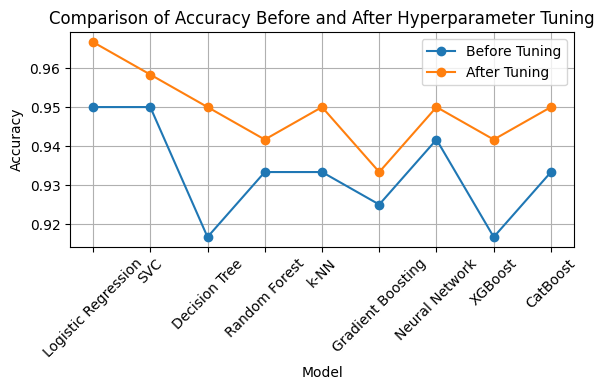

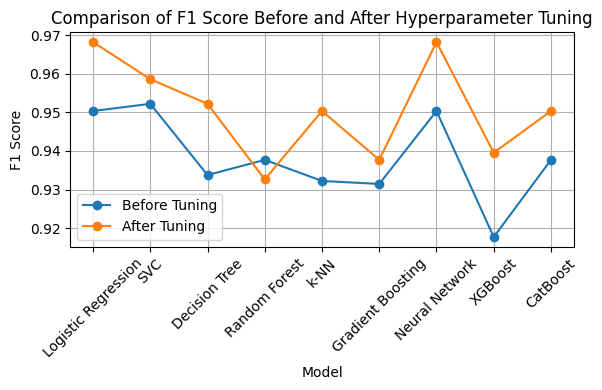

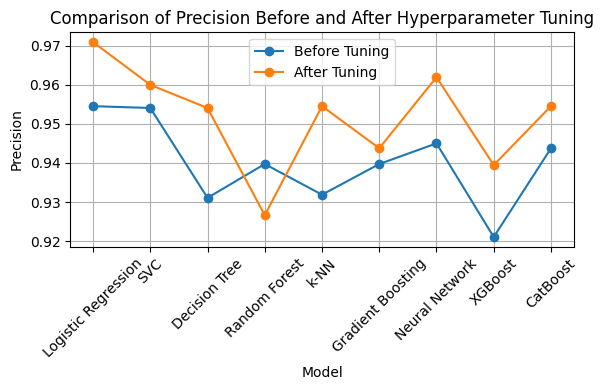

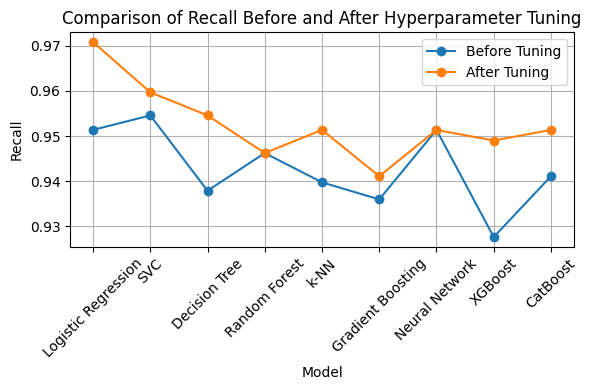

In [49]:
#14. Charts before and after

metrics = ['Accuracy',	'F1 Score',	'Precision',	'Recall']

for metric in metrics:
    plt.figure(figsize=(6, 4))
    plt.plot(df_default['Model'], df_default[metric], marker='o', label='Before Tuning')
    plt.plot(df_tuned['Model'], df_tuned[metric], marker='o', label='After Tuning')
    plt.title(f'Comparison of {metric} Before and After Hyperparameter Tuning')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()